In [1]:
import pandas as pd
import graphviz

In [2]:
class Node:
    def __init__(self,name):
        self.name = name
        self.in_nodes = set()
        self.out_nodes = set()
        
    def add_in_node(self, node):
        self.in_nodes.add(node)
        
    def remove_in_node(self, node):
        self.in_nodes.remove(node)
        
    def add_out_node(self, node):
        self.out_nodes.add(node)
        
    def remove_out_node(self, node):
        self.out_nodes.remove(node)
        
    def depth(self):
        depth = 0
        if self.in_nodes:
            depth = max([ n.depth() + 1 for n in self.in_nodes])
        return depth
                          
    def __str__(self):
        return "{}".format(self.name)

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges_in = {}
        self.edges_out = {}
        self.node_depth = {}
    
    def add_node(self,node):
        self.nodes[node]  = Node(node)
        self.edges_in[node] = []
        self.edges_out[node] = []
        self.node_depth[node] = 0
        
        
    def add_edge(self, node_x, node_y):
        if node_y not in self.edges_out[node_x]:
            print("Adding edge from {} to {}".format(node_x,node_y))
            self.edges_out[node_x].append(node_y)
            self.nodes[node_x].add_out_node(self.nodes[node_y])

            self.edges_in[node_y].append(node_x)
            self.nodes[node_y].add_in_node(self.nodes[node_x])
    
        
    def remove_edge(self, node_x, node_y):
        print("Removing edge from {} to {}".format(node_x,node_y))
        try:
            self.edges_out[node_x].remove(node_y)
            self.nodes[node_x].remove_out_node(self.nodes[node_y])    
            
            self.edges_in[node_y].remove(node_x)
            self.nodes[node_y].remove_in_node(self.nodes[node_x]) 
            
        except ValueError:
            print("Edge does not exist")
     
    def calculate_node_depth(self):
        for alg,node in self.nodes.items():
            self.node_depth[alg] = node.depth()
            
    def get_nodes_at_depth(self,depth):
        #self.calculate_node_depth()
        df = pd.DataFrame(self.node_depth.items())
        return list(df.loc[df[1] == depth][0])
    
    def visualize(self,highlight_nodes=[]):
        g = graphviz.Digraph()
        for node in self.nodes.keys():
            color='#f0efed'
            if node in highlight_nodes:
                color = '#f2ecc7'
            g.node(node,style='filled',color=color)
        for node1,v in self.edges_out.items():
            for node2 in v:
                g.edge(node1, node2)
        return g
        

In [3]:
class Rank:
    def __init__(self, graph):
        self.graph = graph
        self.start = self.graph.get_nodes_at_depth(0)[0]
        self.preset = graph.edges_in.copy()
        self.visited_sets = []
        self.deleted_sets = []
                
    def next_unvisited_preset2(self,start):
        queue = []
        queue.append(start)
        while queue:
            alg = queue.pop(0)
            in_nodes = self.graph.edges_in[alg].copy()
            unvisited = []
            for node in in_nodes:
                node_set = {node,alg}
                if node_set not in self.visited_sets:
                    unvisited.append(node)
                    self.visited_sets.append(node_set)
                    
            if unvisited:
                return (unvisited, alg)
            
            elif self.graph.edges_out[alg]:
                for alg_x in self.graph.edges_out[alg]:
                    queue.append(alg_x)
        return (None,None)
    
    
    
    def compare_preset(self, preset, alg_y):
        x_gt_y = []
        x_eq_y = []
        for alg_x in preset:
            ret = compare(alg_x,alg_y)
            if ret == 2:
                x_gt_y.append(alg_x)
            elif ret == 1:
                x_eq_y.append(alg_x)
        return (x_gt_y, x_eq_y)
    
    def add_edges_from_depth(self,depth,alg_y):
        add_edges=[]
        if depth>=0:
            add_edges.append(self.graph.get_nodes_at_depth(depth))
          
        for alg_x in add_edges:
            self.graph.add_edge(alg_x,alg_y)
            
    
    def reverse_edges(self, x_gt_y, alg_y):
        #depth = self.graph.node_depth[alg_y]-2
        for alg_x in x_gt_y:
            self.graph.remove_edge(alg_x,alg_y)
            self.graph.add_edge(alg_y,alg_x)
            
    def remove_edges_from_nodes(self, from_nodes,alg_y):
        for alg_x in from_nodes:
            self.graph.remove_edge(alg_x,alg_y)
            
    def add_edges_from_nodes(self, from_nodes,alg_y):
        for alg_x in from_nodes:
            #print("adding edge from  {} to {}".format(alg_x, alg_y))
            if {alg_x, alg_y} not in self.deleted_sets:
                self.graph.add_edge(alg_x,alg_y)
            
            
    def remove_edges_to_nodes(self, to_nodes,alg_x):
        for alg_y in to_nodes:
            self.graph.remove_edge(alg_x,alg_y)
            
    def add_edges_to_nodes(self, to_nodes,alg_x):
        for alg_y in to_nodes:
            if {alg_y, alg_x} not in self.deleted_sets:
                self.graph.add_edge(alg_x,alg_y)
            
    
    def modify_graph(self,preset,alg_y):
        x_gt_y, x_eq_y = self.compare_preset(preset, alg_y)
            
        if x_gt_y or len(x_eq_y) == len(preset):
            self.graph.calculate_node_depth()
            depth_above = self.graph.node_depth[alg_y]-2
            depth_below = self.graph.node_depth[alg_y]+1
            from_nodes = self.graph.get_nodes_at_depth(depth_above)
            to_nodes = self.graph.get_nodes_at_depth(depth_below)

            self.add_edges_from_nodes(from_nodes,alg_y)
            for alg_x in x_gt_y:
                self.remove_edges_from_nodes(from_nodes,alg_x)


        self.reverse_edges(x_gt_y,alg_y)
        self.remove_edges_from_nodes(x_eq_y,alg_y)
        for alg_x in x_eq_y:
            self.deleted_sets.append({alg_x, alg_y})

        if x_gt_y:
            self.remove_edges_to_nodes(to_nodes, alg_y)
            for alg_x in x_gt_y:
                self.add_edges_to_nodes(to_nodes,alg_x)

        elif len(x_eq_y) == len(preset):
            self.graph.calculate_node_depth()
            d_ = []
            for alg_x in to_nodes:
                if self.graph.node_depth[alg_x] != self.graph.node_depth[alg_y]+1:
                    self.remove_edges_to_nodes([alg_x,],alg_y)
                    #d_.append(alg_x)

            
            equivalent_nodes = self.graph.get_nodes_at_depth(self.graph.node_depth[alg_y])
            to_nodes_ = self.graph.edges_out[alg_y].copy()
            for _x in to_nodes_:
                if _x not in d_:
                    self.add_edges_from_nodes(equivalent_nodes,_x)
                

    def rank_nodes(self):
        root = self.start
        d_graphs = []
        
        preset,alg_y = self.next_unvisited_preset2(root)
        print(preset, alg_y)
        while preset:
            d_graphs.append(self.graph.visualize([alg_y,]))
            self.modify_graph(preset,alg_y)
            preset,alg_y = self.next_unvisited_preset2(alg_y) 
            print(preset, alg_y)

        d_graphs.append(self.graph.visualize([alg_y,]))
        return d_graphs
            
            
        

In [4]:
def init_graph(h0):
    graph = Graph()
    
    for alg in h0:
        graph.add_node(alg)
        
    for i in range(len(h0)):
        if i!=len(h0)-1:
            graph.add_edge(h0[i], h0[i+1])
          
    graph.calculate_node_depth()
    return graph

In [5]:
def compare(alg1, alg2):
    return 1

In [6]:
h0 = ['alg0', 'alg1', 'alg2', 'alg3']
g = init_graph(h0)

Adding edge from alg0 to alg1
Adding edge from alg1 to alg2
Adding edge from alg2 to alg3


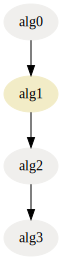

In [7]:
g.visualize(['alg1'])

In [8]:
rank = Rank(g)

In [9]:
history = rank.rank_nodes()

['alg0'] alg1
Removing edge from alg0 to alg1
Adding edge from alg0 to alg2
['alg1', 'alg0'] alg2
Removing edge from alg1 to alg2
Removing edge from alg0 to alg2
Adding edge from alg0 to alg3
Adding edge from alg1 to alg3
['alg2', 'alg0', 'alg1'] alg3
Removing edge from alg2 to alg3
Removing edge from alg0 to alg3
Removing edge from alg1 to alg3
None None


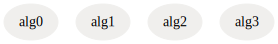

In [10]:
history[-1]

### Real Example

In [11]:
from algorithm_ranking import MeasurementsVisualizer, MeasurementsSimulator, RankVariants

In [12]:
cfg = {}
cfg['alg0']  = [0.1,0.02] #[mean, std]
cfg['alg1']  = [0.15,0.01]
cfg['alg2']  = [0.16,0.02]
cfg['alg3']  = [0.17,0.04]
cfg['alg4']  = [0.20,0.02]
h0 = list(cfg.keys())

In [13]:
ms = MeasurementsSimulator(cfg, 'normal')     

In [14]:
ms.measure(30,1)

In [15]:
data = ms.get_alg_measurements()

In [16]:
h0 = list(cfg.keys())
mv = MeasurementsVisualizer(data, h0)

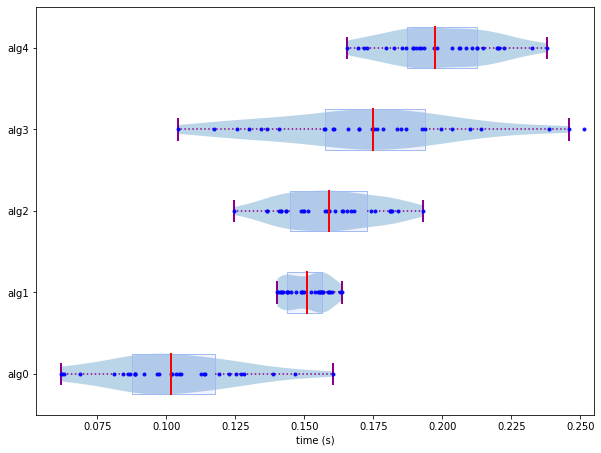

In [17]:
fig = mv.show_measurements_violinplot(h0)

In [18]:
#fig.savefig('v-hypo1.pdf')

In [19]:
rv = RankVariants(data,h0)

In [20]:
#h0.reverse()

In [21]:
h0

['alg0', 'alg1', 'alg2', 'alg3', 'alg4']

In [22]:
compare = rv.compareAlgs

In [23]:
compare('alg1','alg2')

1

In [24]:
g = init_graph(h0)

Adding edge from alg0 to alg1
Adding edge from alg1 to alg2
Adding edge from alg2 to alg3
Adding edge from alg3 to alg4


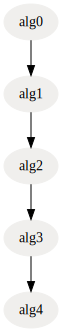

In [25]:
g.visualize()

In [27]:
g.visualize().render('dfg-hypo-h0.pdf')

'dfg-hypo-h0.pdf.pdf'

In [476]:
rank = Rank(g)

In [477]:
history = rank.rank_nodes()

['alg0'] alg1
['alg1'] alg2
Adding edge from alg0 to alg2
Removing edge from alg1 to alg2
Adding edge from alg1 to alg3
['alg0'] alg2
['alg2', 'alg1'] alg3
Adding edge from alg0 to alg3
Removing edge from alg2 to alg3
Removing edge from alg1 to alg3
Adding edge from alg1 to alg4
Adding edge from alg2 to alg4
['alg0'] alg3
['alg3', 'alg1', 'alg2'] alg4
Removing edge from alg3 to alg4
None None


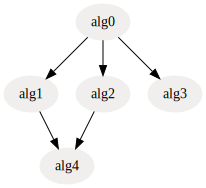

In [478]:
history[6]

In [480]:
history[6].render("dfg-hypo1.pdf")

'dfg-hypo1.pdf.pdf'